# $\Lambda$CDM Inference with MCMC emcee/Nested sampling

## Structure of the Code

In this notebook we are using the PANTHEON+ data, including Cepheid calibrators (https://github.com/PantheonPlusSH0ES/DataRelease) and infer the best-fit parameter values for a $\Lambda$CDM model for two cases:
1. **No-transition Case** :Infer the following three parameters:
    - SN Absolute Magnitude, $M$
    - Hubble Constant, $H_{0}$
    - Present matter density, $\Omega_{m}$ 
2. **Transition Case** :Allow for a transition at the SNe absolute magnitude at some critical distance $d_{crit}$ and infer:
    - Lower Absolute Magnitude Value, $M_{<}$
    - Higher Absolute Magnitude Value, $M_{>}$
    - Hubble Constant, $H_{0}$
    - Present matter density, $\Omega_{m}$
    - Critical distance where transition occurs, $d_{crit}$

To fit the ΛCDM model (both with and without a transition in absolute magnitude), we used two complementary Bayesian inference techniques: **Markov Chain Monte Carlo (MCMC)** via `emcee`, and **nested sampling** via `dynesty`. Each method was chosen for its specific strengths.

---

#### 🔹 `emcee` (MCMC) – for Parameter Estimation

We first used the `emcee` ensemble sampler to perform parameter estimation. This method efficiently explores the posterior distribution of model parameters and provides:

- Accurate estimates of **posterior medians** and **credible intervals**.
- Well-sampled posteriors ideal for **visualization** via corner plots.
- A robust framework for inferring the best-fit cosmological parameters in both models.

**Why `emcee`?**  
It is particularly effective in dealing with high-dimensional, correlated parameter spaces, and is a standard tool for Bayesian parameter inference in cosmology.

---

#### 🔹 Nested Sampling – for Model Comparison

To **compare** the two models (ΛCDM with vs. without a transition), we used **nested sampling**, which provides:

- Posterior samples (like MCMC), and more importantly:
- The **Bayesian evidence** $\mathcal{Z}$ by construction– a quantity that MCMC does not yield.

This evidence allows us to compute the **Bayes factor**:

$$
B_{12} = \frac{\mathcal{Z}_1}{\mathcal{Z}_2}
$$

and assess model preference using the **Jeffreys scale**.

---

#### Summary

- `emcee` was used for **posterior estimation** and visualization.
- Nested sampling was used for **Bayesian model selection** via evidence and Bayes factors.
- This two-step approach provides a complete and robust statistical analysis: parameter constraints and principled model comparison.



## Import all necessary libraries 

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from functools import lru_cache
from numpy.linalg import inv
from IPython.display import display, Math
from IPython.display import Latex, display
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import time
import emcee
import seaborn as sns
from matplotlib.lines import Line2D
import dynesty
import multiprocessing
import corner
from dynesty import utils as dyfunc
from scipy.stats import gaussian_kde

## Load PANTHEON+ data and the Full Covariance Matrix

In [2]:
# Load Pantheon+ light curve data
pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')

# Load and reshape the covariance matrix
with open("sys_full_long-pp.txt", "r") as f:
    lines = f.readlines()

N = int(lines[0].strip())  # Size of the matrix
flat_data = np.array([float(x.strip()) for x in lines[1:]])
C_full = flat_data.reshape((N, N))
C_inv = np.linalg.inv(C_full)  # Invert the full covariance matrix

/var/tmp/stamou/ipykernel_2765823/2683165959.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')


### Preparing the Cosmological Distance Framework

In this cell, we set up the fundamental components needed to compute theoretical predictions for the distance modulus in a flat ΛCDM cosmology. The key steps are:

- **Load the observational data** from the Pantheon+ dataset:
  - `z`: the Hubble diagram redshifts of supernovae,
  - `mB`: the corrected apparent magnitudes,
  - `mu_Ceph`: distance moduli for supernovae with Cepheid host calibrations,
  - `is_calibrator`: a boolean flag identifying which supernovae are used for Cepheid calibration.

- **Define the cosmological model**:
  - We assume a flat ΛCDM universe and define the dimensionless Hubble parameter \( E(z) = H(z)/H_0 \) using the standard expression:
    $$
    E(z) = \sqrt{\Omega_m (1 + z)^3 + (1 - \Omega_m)}
    $$

- **Implement the luminosity distance**:
  - We compute the luminosity distance $ d_L(z) $ by numerically integrating $1/E(z) $ over redshift:
    $$
    d_L(z) = (1 + z) \, c \int_0^z \frac{dz'}{H_0 E(z')}
    $$
  - This calculation is cached using `lru_cache` to improve performance for repeated calls.
  - The final expression for the distance modulus \( \mu(z) \) is then given by:
    $$
    \mu(z) = 5 \log_{10} \left( \frac{d_L(z)}{\text{Mpc}} \right) + 25
    $$
  - We apply this formula across the full array of redshifts to produce theoretical predictions.

This setup allows us to later compare theoretical predictions for supernova brightness with observed values, enabling parameter inference and model fitting.


In [3]:
# Load Hubble Diagram Redshift from PANTHEON
z = pantheon_data['zHD'].values
# Define SNe with Cepheid host
is_calibrator = pantheon_data['IS_CALIBRATOR'].values.astype(int)
# Load the corrected apparent magnitudes and distance moduli from Cepheid hosts
mB = pantheon_data['m_b_corr'].values
mu_Ceph = pantheon_data['CEPH_DIST'].values

# Speed of light in km/s
c_km_s = 299792.458

def E_LCDM(z, Omega_m):
    """Dimensionless Hubble parameter E(z) = H(z)/H0 for flat ΛCDM."""
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

@lru_cache(maxsize=None)
def integral_dL(z, H0, Omega_m):
    """Luminosity distance integral with caching for speed."""
    integrand = lambda zp: 1.0 / E_LCDM(zp, Omega_m)
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

def mu_theory(z_array, H0, Omega_m):
    """Compute theoretical distance modulus for an array of z."""
    return np.array([
        5 * np.log10(integral_dL(float(z), H0, Omega_m)) + 25
        for z in z_array
    ])




### Defining the Likelihood, Posterior, and Priors for the No-Transition ΛCDM Model

In this cell, we define the statistical framework for fitting the no-transition ΛCDM model to the Pantheon+ data using **Bayesian inference** and **MCMC sampling**. The core elements are:

---

#### 🔹 Bayesian Framework

We apply **Bayes' theorem** to obtain the posterior distribution of the cosmological parameters:
$$
P(\theta \mid \text{data}) \propto \mathcal{L}(\text{data} \mid \theta) \, P(\theta)
$$

- \( P(\theta \mid \text{data}) \) is the **posterior**: the probability distribution of the model parameters \( \theta = (M, H_0, \Omega_m) \) given the data.
- \( \mathcal{L}(\text{data} \mid \theta) \) is the **likelihood**: how well the model fits the data for a given parameter set.
- \( P(\theta) \) is the **prior**: our initial knowledge or assumptions about the parameters before seeing the data.

---

#### 🔹 Chi-Square Likelihood Function

We define the likelihood using a Gaussian approximation, which corresponds to a chi-square function:
$$
\chi^2 = \mathbf{Q}^\mathrm{T} \, C^{-1} \, \mathbf{Q}
$$
where $C$ is the covariance matrix given by PANTHEON+ and $Q$ is the residual vector defined as:
$$
\mathbf{Q}' =
\begin{cases}
m_B - M - \mu_{\text{Ceph}} & \text{for calibrator SNe} \\
m_B - M - \mu_{\text{model}}(z, H_0, \Omega_m) & \text{otherwise}
\end{cases}
$$

We treat calibrator and non-calibrator supernovae differently:
- For calibrators, the distance modulus is compared to Cepheid-based values $ \mu_{\text{Ceph}} $.
- For others, it is compared to the theoretical model $ \mu_{\text{model}}(z, H_0, \Omega_m) $.

---

#### 🔹 Posterior Construction

The log-posterior is computed as:
$$
\log P(\theta \mid \text{data}) = -\frac{1}{2} \chi^2(\theta)
$$

Flat (uniform) priors are imposed as hard boundaries. If a proposed set of parameters falls outside the prior bounds, the posterior is set to \( -\infty \), effectively rejecting the sample.

---

#### 🔹 Prior Choices

We use **uninformative flat priors** to minimally constrain the parameters:

- $ M \in [-20.0, -18.0] $: Absolute magnitude of Type Ia supernovae.
- $ H_0 \in [65.0, 78.0] $: Hubble constant in km/s/Mpc.
- $ \Omega_m \in [0.1, 0.8] $: Present-day matter density parameter.

These intervals are chosen to include plausible cosmological values while remaining agnostic about the outcome.

---

This framework allows us to sample from the posterior distribution of the ΛCDM parameters using `emcee` and quantify uncertainties on the model fit to the data.


In [ ]:
# --- Chi-Square Function ---
def chi2(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    """
    Compute chi2 using modified residual vector Q' following Perivolaropoulos & Skara.
    """
    M, H0, Omega_m = params
    mu_model = mu_theory(z, H0, Omega_m)
    
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(
            z >= 0.0,  
            mB - M - mu_model,
            0.0  
        )
    )
    
    return Q.T @ C_inv @ Q

# --- Log-Posterior Function ---
def log_posterior(params, z, mB, mu_Ceph, is_calibrator, C_inv, priors):
    
    M, H0, Omega_m = params
    
    # Unpack prior bounds
    M_min, M_max = priors['M']
    H0_min, H0_max = priors['H0']
    Omega_m_min, Omega_m_max = priors['Omega_m']
    
    # Flat priors (hard boundaries)
    if not (M_min <= M <= M_max and H0_min <= H0 <= H0_max and Omega_m_min <= Omega_m <= Omega_m_max):
        return -np.inf  # Reject proposals outside bounds
    
    chi2_val = chi2(params, z, mB, mu_Ceph, is_calibrator, C_inv)
    
    return -0.5 * chi2_val

priors = {
    'M': (-20.0, -18.0),         # Absolute magnitude of SNeIa
    'H0': (65.0, 78.0),          # Hubble constant in km/s/Mpc
    'Omega_m': (0.1, 0.8)        # Matter density parameter
}

### MCMC Sampler | `emcee` in Python

After establishing the theoretical model and defining the likelihood and prior distributions, we now sample the posterior distribution of the ΛCDM parameters using the **Markov Chain Monte Carlo (MCMC)** method, implemented via Python's `emcee` sampler.

The sampling process proceeds as follows:

- We define **32 walkers** to explore the parameter space in parallel.
- Each walker performs **4000 steps**, proposing new parameter values at each step.
- At each step, the **log-posterior** is evaluated, which includes the likelihood (based on chi-square) and the prior.
- The algorithm decides whether to accept or reject a proposed step based on the relative posterior probability. This allows the walkers to collectively move toward regions of higher probability density.
- The first **800 steps** are treated as **burn-in**, allowing the chains to converge and "forget" their initial positions. These steps are discarded.
- The remaining samples form a representative sample from the **posterior distribution**.

Additionally:
- The flattened posterior samples (after burn-in) are saved to disk for further analysis and plotting.
- The full raw MCMC chain is saved as well for convergence diagnostics or trace plots.

This sampling procedure allows us to estimate credible intervals, correlations between parameters, and the overall shape of the posterior surface in the 3D parameter space defined by $M$, $H_0$, and $\Omega_m$.


In [5]:
start_time = time.time()

# --- MCMC with emcee ---
def run_emcee(z, mB, mu_Ceph, is_calibrator, C_inv, priors,
              n_walkers=32, n_steps=4000, burn_in=800):
    
    ndim = 3  # Number of parameters (M, H0, Omega_m)
    
    # --- Initialize walkers ---
    np.random.seed(42)
    initial_positions = np.array([
        [
            np.random.uniform(*priors['M']),
            np.random.uniform(*priors['H0']),
            np.random.uniform(*priors['Omega_m'])
        ]
        for _ in range(n_walkers)
    ])
    
    # --- Define sampler ---
    sampler = emcee.EnsembleSampler(
        n_walkers,
        ndim,
        log_posterior,
        args=(z, mB, mu_Ceph, is_calibrator, C_inv, priors)
    )
    
    # --- Run MCMC ---
    sampler.run_mcmc(initial_positions, n_steps, progress=True)

    # --- Get flattened chain (after burn-in) ---
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    # ✅ Save flattened samples
    np.save("samples_chain_4000steps.npy", samples)

    # ✅ Optional: Save full raw chain for diagnostics (optional but useful)
    full_chain = sampler.get_chain()
    np.save("full_sampler_chain_4000steps.npy", full_chain)

    return samples, sampler

# --- Run the sampler ---
samples, sampler = run_emcee(
    z,
    mB,
    mu_Ceph,
    is_calibrator,
    C_inv,
    priors,
    n_walkers=32,
    n_steps=4000,
    burn_in=800
)

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

 


100%|█████████████████████████████████████| 4000/4000 [4:07:43<00:00,  3.72s/it]


⏱️ Execution time: 14867.37 seconds


# Chain Plot of Inferred Values

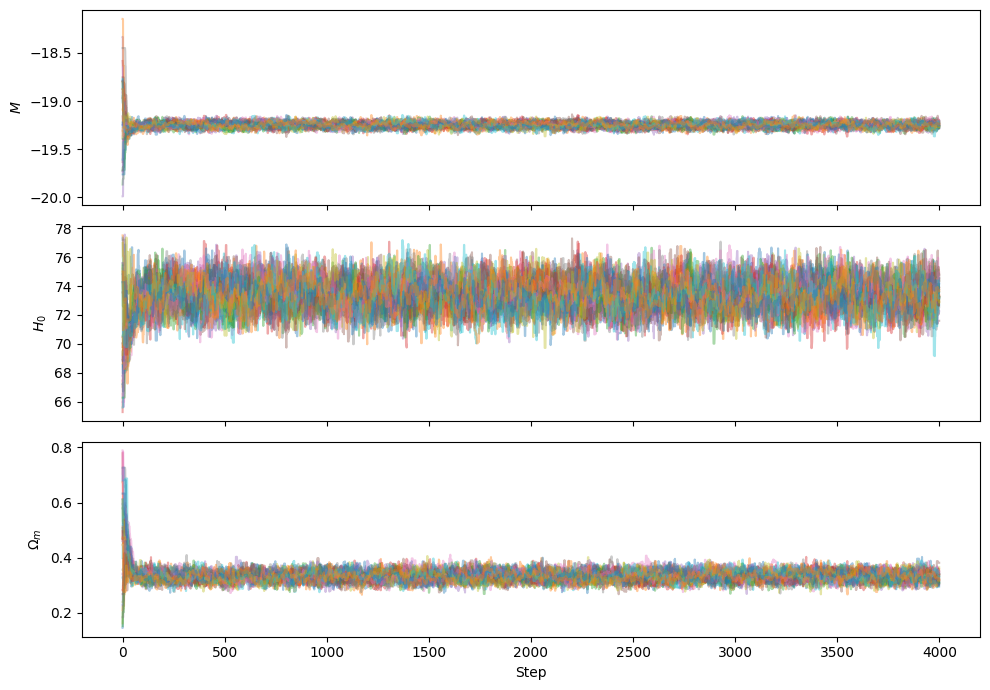

In [6]:
samples = np.load("samples_chain_4000steps.npy")
# Load the full chain: shape (n_steps, n_walkers, n_params)
full_chain = np.load("full_sampler_chain_4000steps.npy")
param_labels = [r"$M$", r"$H_0$", r"$\Omega_m$"]


fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)

for i in range(3):
    for walker in range(full_chain.shape[1]):
        axes[i].plot(full_chain[:, walker, i], alpha=0.4)
    axes[i].set_ylabel(param_labels[i])
axes[-1].set_xlabel("Step")
plt.tight_layout()
# Save to file
fig.savefig("chain_plot.png", dpi=300)
plt.show()



# Conrer Plot

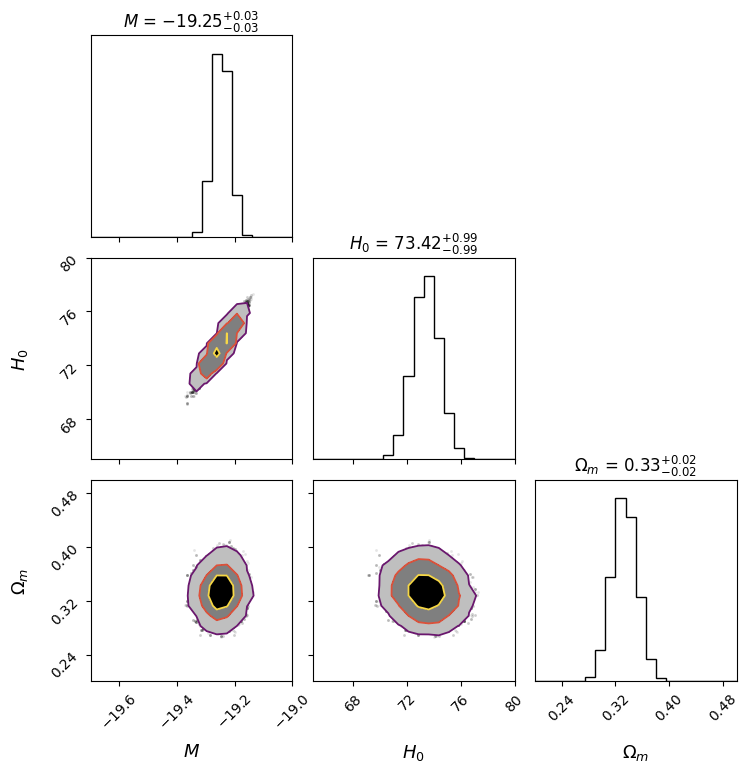

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
# Load samples
samples = np.load("Saved Samples/samples_chain_4000steps.npy")
param_labels = [r"$M$", r"$H_0$", r"$\Omega_m$"]

# Define levels
levels = [0.68, 0.95, 0.997]

cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.3, 0.9, len(levels))]
# Define axis ranges for cleaner framing
ranges = [
    (-19.7, -19.0),  # M
    (65, 80),        # H0
    (0.2, 0.5)       # Omega_m
]

# Plot corner plot
fig_no = corner.corner(
    samples,
    labels=param_labels,
    show_titles=True,
    title_fmt=".2f",
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    range=ranges,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12},
    max_n_ticks=4,
    use_math_text=True
)

# Tidy up spacing
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)

# Save to file
fig_no.savefig("corner_plot_colormap_final.png", dpi=300)
plt.show()

# Parameter labels and units
param_labels = [
    r"M", 
    r"H_0", 
    r"\Omega_m"
]
units = ["", r"\,\mathrm{km/s/Mpc}", ""]

# Compute medians and 68% credible intervals
medians = np.median(samples, axis=0)
lower = np.percentile(samples, 16, axis=0)
upper = np.percentile(samples, 84, axis=0)

# Display LaTeX-formatted output
display(Math(r"\textbf{Posterior medians with 68\% credible intervals:}"))
for label, med, low, up, unit in zip(param_labels, medians, lower, upper, units):
    err_minus = med - low
    err_plus = up - med
    display(Math(rf"{label} = {med:.3f}^{{+{err_plus:.3f}}}_{{-{err_minus:.3f}}}{unit}"))



## Defining the Likelihood, Posterior, and Priors for the Transition ΛCDM Model

In this step, we extend our previous Bayesian framework to include a **transition** in the absolute magnitude of supernovae. This is motivated by potential deviations from homogeneity or isotropy, as proposed in the methodology of Perivolaropoulos & Skara (https://arxiv.org/pdf/2301.01024).

---

#### 🔹 Transition Model Overview

The key idea is to allow the absolute magnitude $M$ of Type Ia supernovae to transition between two values—$M_{<}$ and $M_{>}$—depending on whether the inferred distance modulus is below or above a critical threshold.

We define:
- $M_{<}$: the absolute magnitude below the transition,
- $M_{>}$: the absolute magnitude above the transition,
- $d_{\mathrm{crit}}$: the critical luminosity distance at which the transition occurs,
- $\mu_{\mathrm{crit}} = 5 \log_{10}(d_{\mathrm{crit}}) + 25$: the corresponding critical distance modulus.

To determine which magnitude to use, we define an empirical quantity:
$$
\mu_{\mathrm{SH0ES}} = m_B + 19.253
$$
and apply the transition condition:
$$
M =
\begin{cases}
M_{<} & \text{if } \mu_{\mathrm{SH0ES}} < \mu_{\mathrm{crit}} \\
M_{>} & \text{otherwise}
\end{cases}
$$

---

#### 🔹 Chi-Square Likelihood Function

We construct a chi-square statistic based on the modified residuals:
$$
\chi^2 = \mathbf{Q}^\mathrm{T} C^{-1} \mathbf{Q}
$$
where the residual vector is now defined as:
$$
\mathbf{Q}' =
\begin{cases}
m_B - M_{<} - \mu_{\text{Ceph}}, & \text{if calibrator and } \mu_{\mathrm{SH0ES}} < \mu_{\mathrm{crit}} \\
m_B - M_{>} - \mu_{\text{Ceph}}, & \text{if calibrator and } \mu_{\mathrm{SH0ES}} \geq \mu_{\mathrm{crit}} \\
m_B - M_{<} - \mu_{\text{model}}, & \text{if non-calibrator and } \mu_{\mathrm{SH0ES}} < \mu_{\mathrm{crit}} \\
m_B - M_{>} - \mu_{\text{model}}, & \text{if non-calibrator and } \mu_{\mathrm{SH0ES}} \geq \mu_{\mathrm{crit}}
\end{cases}
$$

---

#### 🔹 Posterior and Priors

The **log-posterior** is defined as:
$$
\log P(\theta \mid \text{data}) = -\frac{1}{2} \chi^2(\theta)
$$
subject to **uniform priors** for each parameter:
- $M_{<}, M_{>} \in [-20.0, -18.0]$
- $H_0 \in [60.0, 80.0]$
- $\Omega_m \in [0.1, 0.5]$
- $d_{\mathrm{crit}} \in [15.0, 25.0]$

If any parameter falls outside these ranges, the log-posterior is set to $-\infty$, rejecting the proposal.

---

This setup allows us to explore whether a data-driven transition in $M$ improves the fit to the Hubble diagram, compared to the standard no-transition ΛCDM model.


In [4]:
def chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    """
    Compute chi2 for the transition model using Perivolaropoulos & Skara methodology.
    """
    M_low, M_high, H0, Omega_m, d_crit = params
    
    mu_model = mu_theory(z, H0, Omega_m)
    mu_SH0ES = mB + 19.253
    mu_crit = 5 * np.log10(d_crit) + 25
    
    # Decide which M to use: M_low for mu_SH0ES < mu_crit, else M_high
    M_used = np.where(mu_SH0ES < mu_crit, M_low, M_high)
    
    Q = np.where(
        is_calibrator == 1,
        mB - M_used - mu_Ceph,
        mB - M_used - mu_model
    )
    
    return Q.T @ C_inv @ Q

priors_transition = {
    'M_low': (-20.0, -18.0),      # Lower absolute magnitude
    'M_high': (-20.0, -18.0),     # Higher absolute magnitude
    'H0': (60.0, 80.0),           # Hubble constant
    'Omega_m': (0.1, 0.5),        # Matter density
    'd_crit': (15.0,25.0)        # Critical distance modulus
}
def log_posterior_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, priors):
    """
    Compute log-posterior for transition model:
    - Flat priors defined by `priors` dict
    - Log-likelihood based on chi2
    """
    # Unpack parameter values
    M_low, M_high, H0, Omega_m, d_crit = params
    
    # Unpack prior bounds
    prior_bounds = list(priors.values())
    for val, (low, high) in zip(params, prior_bounds):
        if not (low <= val <= high):
            return -np.inf  # outside prior → zero probability
    
    # Compute log-likelihood
    chi2_val = chi2_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2_val

### MCMC Sampler | Transition ΛCDM Model via `emcee`

Having defined the likelihood and priors for the transition ΛCDM model, we now proceed to sample its posterior using the **`emcee`** ensemble sampler. This setup builds on the earlier no-transition case, but now includes **five parameters**: $M_{<}$, $M_{>}$, $H_0$, $\Omega_m$, and $d_{\mathrm{crit}}$.

---

#### 🔹 MCMC Setup and Sampling Strategy

We define a function `run_emcee_transition` that encapsulates the entire MCMC procedure:

- **Parameter space**: We are sampling in a 5-dimensional space corresponding to the model parameters.
- **Steps** : We are using **5000 steps** for the walkers and 1000 burn-ins so the chain can safely converge.
- **Walkers**: We use **32 walkers**, each initialized randomly within the prior bounds for each parameter.
- **Initial positions**: For each walker, an initial position is drawn uniformly from the flat prior ranges defined in `priors_transition`.

---

#### 🔹 Parallel Sampling with `multiprocessing`

To speed up the MCMC process, we use Python’s `multiprocessing.Pool()` to run the ensemble sampler in parallel. This allows the walkers to evaluate their log-posterior independently and simultaneously.



In [5]:
start_time=time.time()

def run_emcee_transition(z, mB, mu_Ceph, is_calibrator, C_inv, priors,
                         n_walkers=32, n_steps=5000, burn_in=1000):
    
    ndim = 5  # Number of parameters: M_low, M_high, H0, Omega_m, d_crit

    # --- Initialize walkers uniformly within prior ranges ---
    np.random.seed(42)
    initial_positions = np.array([
        [
            np.random.uniform(*priors['M_low']),
            np.random.uniform(*priors['M_high']),
            np.random.uniform(*priors['H0']),
            np.random.uniform(*priors['Omega_m']),
            np.random.uniform(*priors['d_crit'])
        ]
        for _ in range(n_walkers)
    ])

    # --- Parallel sampling with emcee + multiprocessing ---
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            n_walkers,
            ndim,
            log_posterior_transition,
            args=(z, mB, mu_Ceph, is_calibrator, C_inv, priors),
            pool=pool
        )

        # --- Run MCMC ---
        sampler.run_mcmc(initial_positions, n_steps, progress=True)

    # --- Get flattened chain (after burn-in) ---
    samples = sampler.get_chain(discard=burn_in, flat=True)

    # ✅ Save for reuse
    np.save("samples_transition_5000steps.npy", samples)
    np.save("full_chain_transition.npy", sampler.get_chain())

    return samples, sampler
samples_transition, sampler_transition = run_emcee_transition(
    z,
    mB,
    mu_Ceph,
    is_calibrator,
    C_inv,
    priors_transition,
    n_walkers=32,
    n_steps=5000,
    burn_in=1000
)
end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [3:40:44<00:00,  2.65s/it]


⏱️ Execution time: 13253.69 seconds


## Chain Plot

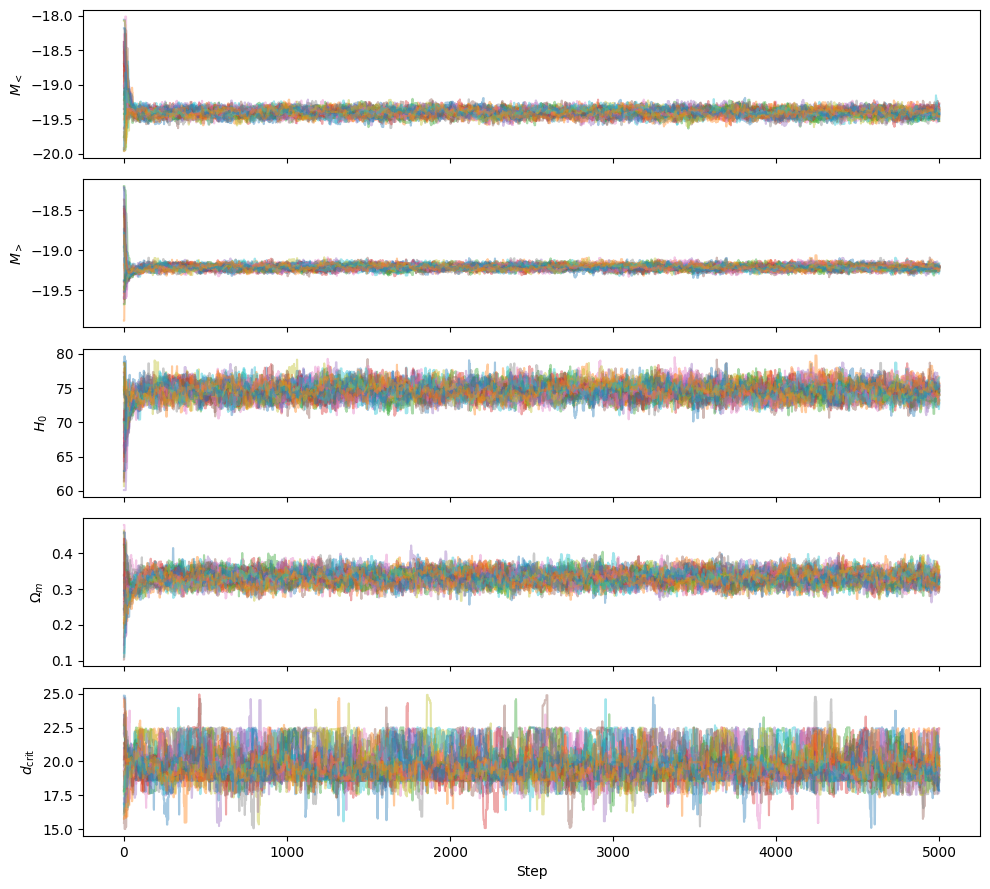

In [6]:
# Load samples and full chain
samples = np.load("samples_transition_5000steps.npy")
full_chain = np.load("full_chain_transition.npy")

# Parameter labels for transition model
param_labels = [r"$M_{<}$", r"$M_{>}$", r"$H_0$", r"$\Omega_m$", r"$d_{\mathrm{crit}}$"]

# Create chain plot
fig, axes = plt.subplots(5, figsize=(10, 9), sharex=True)

for i in range(5):
    for walker in range(full_chain.shape[1]):
        axes[i].plot(full_chain[:, walker, i], alpha=0.4)
    axes[i].set_ylabel(param_labels[i])

axes[-1].set_xlabel("Step")
plt.tight_layout()

# Save to file
fig.savefig("chain_plot_transition.png", dpi=300)
plt.show()



## Corner Plot

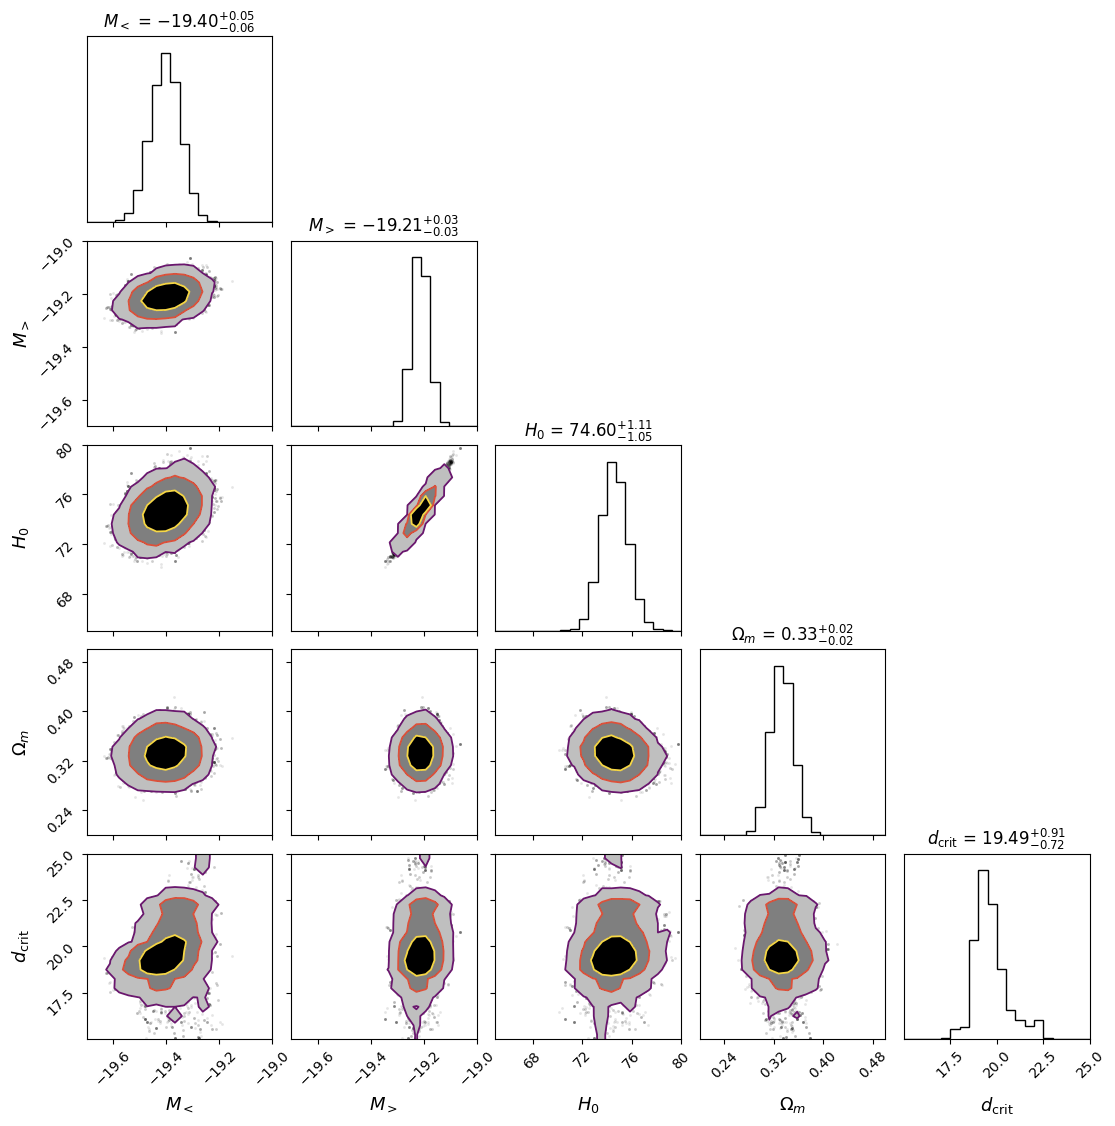

In [5]:
# Load samples
samples = np.load("Saved Samples/samples_transition_5000steps.npy")

# Updated parameter labels for transition model
param_labels = [
    r"$M_{<}$", 
    r"$M_{>}$", 
    r"$H_0$", 
    r"$\Omega_m$", 
    r"$d_{\mathrm{crit}}$"
]

# Define confidence levels
levels = [0.68, 0.95, 0.997]

# Set colormap and contour colors
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.3, 0.9, len(levels))]

# Custom axis ranges
ranges = [
    (-19.7, -19.0),  # M_<
    (-19.7, -19.0),  # M_>
    (65, 80),        # H_0
    (0.20, 0.50),    # Omega_m
    (15, 25)         # d_crit
]

# Create corner plot
fig_tr = corner.corner(
    samples,
    labels=param_labels,
    show_titles=True,
    title_fmt=".2f",
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    range=ranges,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12},
    max_n_ticks=4,
    use_math_text=True
)

# Tidy up spacing
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)


# Save to file
fig_tr.savefig("corner_plot_transition_model.png", dpi=300)
plt.show()


In [10]:
# Labels
param_labels = [r"M_{<}", r"M_{>}", r"H_0", r"\Omega_m", r"d_{\mathrm{crit}}"]
units = ["", "", r"\,\mathrm{km/s/Mpc}", "", r"\,\mathrm{Mpc}"]

# Compute median and 1σ credible intervals
medians = np.median(samples, axis=0)
lower = np.percentile(samples, 16, axis=0)
upper = np.percentile(samples, 84, axis=0)

# Display as LaTeX
display(Math(r"\textbf{Posterior medians with 68\% CI:}"))
for i in range(len(param_labels)):
    median = medians[i]
    err_minus = median - lower[i]
    err_plus = upper[i] - median
    display(Math(
        rf"{param_labels[i]} = {median:.3f}^{{+{err_plus:.3f}}}_{{-{err_minus:.3f}}}{units[i]}"
    ))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Nested Sampling Setup | No-Transition ΛCDM Model

In this section, we prepare the components needed to perform **Bayesian nested sampling** for the standard ΛCDM model without a transition in the supernova absolute magnitude. Nested sampling requires us to define the **log-likelihood** and a **prior transform** that maps points from the unit cube to the physical parameter space.

---

#### 🔹 Parameter Space and Priors

We define uniform (flat) priors over the following parameter ranges:

- $M \in [-20.0, -18.0]$: Absolute magnitude of Type Ia supernovae.
- $H_0 \in [65.0, 78.0]$: Hubble constant in km/s/Mpc.
- $\Omega_m \in [0.1, 0.8]$: Matter density parameter.

These are encoded in the dictionary `priors_notransition`.

---

#### 🔹 Prior Transform

Nested sampling algorithms (like `dynesty`) internally sample from a **unit cube**, where each parameter $u_i \in [0, 1]$. We define a `prior_transform_notransition(u)` function that maps each $u_i$ to its corresponding physical parameter value using a linear rescaling:

$$
\theta_i = \theta_{\min} + u_i (\theta_{\max} - \theta_{\min})
$$

This allows the nested sampler to draw samples within the valid physical region.

---

#### 🔹 Chi-Square Function

We define a chi-square function `chi2_notransition` using the residual formulation from Perivolaropoulos & Skara. The residual vector $\mathbf{Q}$ compares the observed supernova data with either:
- The Cepheid-based distance modulus $\mu_{\text{Ceph}}$ for calibrators, or
- The theoretical cosmological prediction $\mu_{\text{model}}(z, H_0, \Omega_m)$ for non-calibrators.

The chi-square statistic is given by:
$$
\chi^2 = \mathbf{Q}^\mathrm{T} C^{-1} \mathbf{Q}
$$
with the residual vector given by:
$$
\begin{cases}
m_B - M - \mu_{\text{Ceph}} & \text{for calibrator SNe} \\
m_B - M - \mu_{\text{model}}(z, H_0, \Omega_m) & \text{otherwise}
\end{cases}
$$

---

#### 🔹 Log-Likelihood Function

The log-likelihood function for nested sampling is defined as:
$$
\log \mathcal{L} = -\frac{1}{2} \chi^2(\theta)
$$

This is implemented in `log_likelihood_notransition`, which computes the chi-square for a given parameter set $\theta = (M, H_0, \Omega_m)$ and returns the corresponding log-likelihood value.

---

With the prior transform and log-likelihood in place, we are now ready to initialize and run the nested sampler using a tool like `dynesty`.


In [9]:
priors_notransition = {
    'M': (-20.0, -18.0),
    'H0': (65.0, 78.0),
    'Omega_m': (0.1, 0.8)
}
# Prior transform: unit cube → physical space
def prior_transform_notransition(u):
    """
    u: 1D array with elements in [0, 1]
    Maps to physical parameters using uniform priors
    """
    M_min, M_max = priors_notransition['M']
    H0_min, H0_max = priors_notransition['H0']
    Om_min, Om_max = priors_notransition['Omega_m']
    
    M = M_min + u[0] * (M_max - M_min)
    H0 = H0_min + u[1] * (H0_max - H0_min)
    Omega_m = Om_min + u[2] * (Om_max - Om_min)
    
    return [M, H0, Omega_m]


def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    """
    Compute chi2 for the no-transition model:
    M, H0, Omega_m
    """
    M, H0, Omega_m = params

    # Theoretical distance modulus
    mu_model = mu_theory(z, H0, Omega_m)

    # Residual vector Q (Perivolaropoulos & Skara definition)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        mB - M - mu_model
    )

    return Q.T @ C_inv @ Q



def log_likelihood_notransition(theta):
    """
    Returns log-likelihood = -0.5 * chi^2
    """
    M, H0, Omega_m = theta
    chi2 = chi2_notransition([M, H0, Omega_m], z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2

## Define and run the `dynesty` sampler

### No-Transition ΛCDM Model

In this cell, we run the nested sampling algorithm using the `dynesty.NestedSampler` to sample the posterior and compute the Bayesian evidence for the standard ΛCDM model (without a transition in $M$).

- We define a 3-dimensional parameter space: $M$, $H_0$, and $\Omega_m$.
- The `prior_transform` maps unit cube samples to the physical prior ranges.
- The log-likelihood is based on the $\chi^2$ defined using Perivolaropoulos & Skara’s residuals.
- We use `sample='rwalk'` and `bound='multi'` to efficiently explore the posterior, including non-Gaussian features.
- Multiprocessing is enabled to parallelize the sampling across available CPU cores.

We use **500 live points** (`nlive=500`) for the nested sampling run. This is a common and sufficient choice for accurate posterior reconstruction and reliable evidence estimation in low-dimensional spaces (like our 3-parameter model). The same value is also used for the 5-parameter transition model below, offering a consistent and computationally efficient setup for model comparison.


In [10]:
# Enable multiprocessing
with multiprocessing.Pool() as pool:
    dsampler_no = dynesty.NestedSampler(
        log_likelihood_notransition,
        prior_transform_notransition,
        ndim=3,
        nlive=500,  
        sample='rwalk',
        bound='multi',
        pool=pool,
        queue_size=multiprocessing.cpu_count()
    )

    dsampler_no.run_nested(print_progress=True)
    results_no_transition = dsampler_no.results



5368it [1:06:02,  1.35it/s, +500 | bound: 40 | nc: 1 | ncall: 106973 | eff(%):  5.511 | loglstar:   -inf < -761.496 <    inf | logz: -771.447 +/-  0.137 | dlogz:  0.001 >  0.509]


### Extracting Posterior Samples and Bayesian Evidence | No-Transition Model

In this cell, we extract and process the results of the nested sampling run for the no-transition ΛCDM model.

- `results_no_transition = dsampler_no.results` retrieves the full output of the sampler, including posterior samples, log-weights, and log-evidence.
- The posterior samples are weighted using the expression:
  $$
  w_i = \exp(\log w_i - \log \mathcal{Z})
  $$
  These are then **resampled with equal weights** using `dyfunc.resample_equal(...)` to produce a representative posterior sample (`samples_no_transition_post`).
- The posterior samples are saved to a `.npy` file for reuse in corner plots or best-fit estimation.
- The Bayesian **log-evidence** is extracted using:
  - `logZ_no = results_no_transition.logz[-1]`
  - `logZerr_no = results_no_transition.logzerr[-1]`

---

#### 🔹 Importance of the Bayesian Evidence

The log-evidence $\log \mathcal{Z}$ represents the integrated likelihood over the prior volume. It quantifies **how well the model explains the data while accounting for model complexity**.

- It is **not** just a measure of best-fit quality, but of the entire posterior structure.
- This allows for **model comparison** using the **Bayes factor**:
  $$
  B_{12} = \frac{\mathcal{Z}_1}{\mathcal{Z}_2}
  $$

The difference in log-evidence, $\Delta \log \mathcal{Z}$, provides a principled way to decide whether the data favor the transition model over the no-transition model, as interpreted using the **Jeffreys scale**.


In [11]:
results_no_transition = dsampler_no.results
# Posterior samples
samples_no_transition, weights = results_no_transition.samples, np.exp(results_no_transition.logwt - results_no_transition.logz[-1])
samples_no_transition_post = dyfunc.resample_equal(samples_no_transition, weights)

# Save to file for later plotting
np.save("posterior_samples_no_transition.npy", samples_no_transition_post)
# Log-evidence
logZ_no = results_no_transition.logz[-1]
logZerr_no = results_no_transition.logzerr[-1]

print(f"logZ (No-Transition): {logZ_no:.2f} ± {logZerr_no:.2f}")


logZ (No-Transition): -771.45 ± 0.24


## Corner Plot and Best-Fit Values | No-Transition $\Lambda$CDM Model

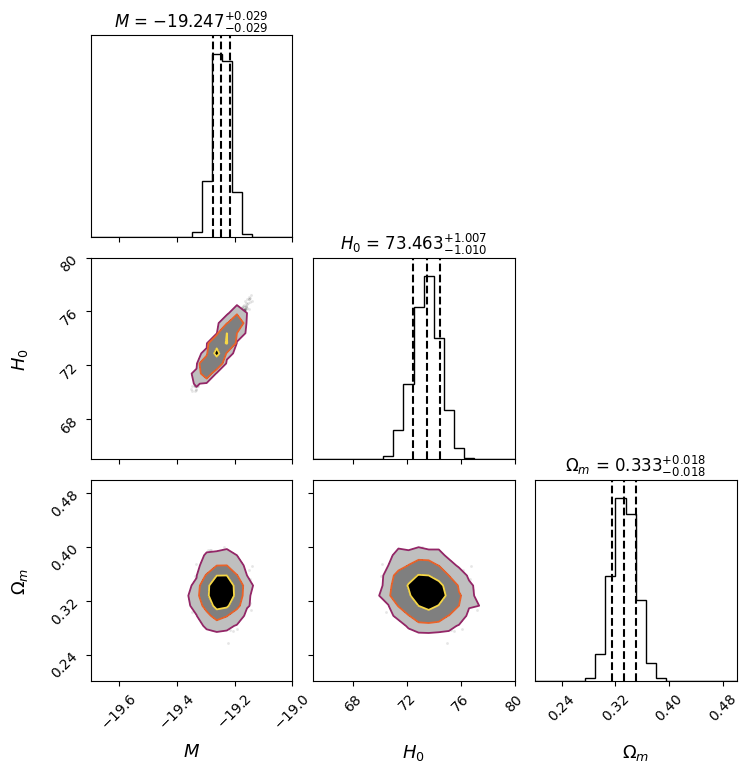

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [31]:
# Load the posterior samples for the no-transition case
samples_no_transition_post = np.load("Saved Samples/posterior_samples_no_transition.npy")

# Parameter labels 
param_labels = [
    r"$M$",
    r"$H_0$",
    r"$\Omega_m$"
]

# Color map setup
cmap = plt.colormaps["inferno"]
levels = [0.68, 0.95, 0.997]
colors = [cmap(x) for x in np.linspace(0.4, 0.9, len(levels))]

# Axis ranges
ranges = [
    (-19.7, -19.0),  # M
    (65, 80),        # H0
    (0.20, 0.50)     # Omega_m
]

# Generate the corner plot
fig = corner.corner(
    samples_no_transition_post,
    labels=param_labels,
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 13},
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    max_n_ticks=4,
    use_math_text=True,
    range=ranges
)

# Layout adjustments
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)

fig.savefig("corner_dynesty_no_transition.png", dpi=300)
plt.show()

param_labels = [r"M", r"H_0", r"\Omega_m"]

for i, label in enumerate(param_labels):
    median = np.median(samples_no_transition_post[:, i])
    lower = np.percentile(samples_no_transition_post[:, i], 16)
    upper = np.percentile(samples_no_transition_post[:, i], 84)
    err_minus = median - lower
    err_plus = upper - median

    display(Math(rf"{label} = {median:.5f}^{{+{err_plus:.5f}}}_{{-{err_minus:.5f}}}"))


# Nested Sampling | Transition in Absolute Magnitude-$\Lambda$CDM Inference

Just an update of the previous case to include 5 parameters instead of 3.

In [5]:
priors_transition = {
    'M_low': (-20.0, -18.0),
    'M_high': (-20.0, -18.0),
    'H0': (65.0, 78.0),
    'Omega_m': (0.1, 0.8),
    'd_crit': (15.0, 25.0)
}

def prior_transform_transition(u):
    """
    Maps unit cube [0,1]^5 → physical parameter space using uniform priors
    """
    keys = list(priors_transition.keys())
    theta = []
    for i in range(5):
        low, high = priors_transition[keys[i]]
        theta.append(low + u[i] * (high - low))
    return theta

def log_likelihood_transition(theta):
    """
    Returns log-likelihood = -0.5 * chi^2 for transition model
    """
    chi2 = chi2_transition(theta, z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2

In [6]:
with multiprocessing.Pool() as pool:
    dsampler = dynesty.NestedSampler(
        log_likelihood_transition,
        prior_transform_transition,
        ndim=5,
        nlive=500,
        sample='rwalk',
        bound='multi',
        pool=pool,
        queue_size=multiprocessing.cpu_count()
    )

    dsampler.run_nested(print_progress=True)
    results_transition = dsampler.results


8152it [1:53:09,  1.20it/s, +500 | bound: 73 | nc: 1 | ncall: 192600 | eff(%):  4.504 | loglstar:   -inf < -751.717 <    inf | logz: -767.490 +/-  0.181 | dlogz:  0.001 >  0.509]


## Evidence Calculation for Transition Case

In [7]:
# Equal-weight posterior samples
samples_transition, weights = results_transition.samples, np.exp(results_transition.logwt - results_transition.logz[-1])
samples_transition_post = dyfunc.resample_equal(samples_transition, weights)

# Save to file for later plotting
np.save("posterior_samples_transition.npy", samples_transition_post)

# Log-evidence
logZ_trans = results_transition.logz[-1]
logZerr_trans = results_transition.logzerr[-1]
print(f"logZ (Transition): {logZ_trans:.2f} ± {logZerr_trans:.2f}")

logZ (Transition): -767.49 ± 0.28


## Corner Plot and Best-Fit Values | Transition $\Lambda$CDM Model

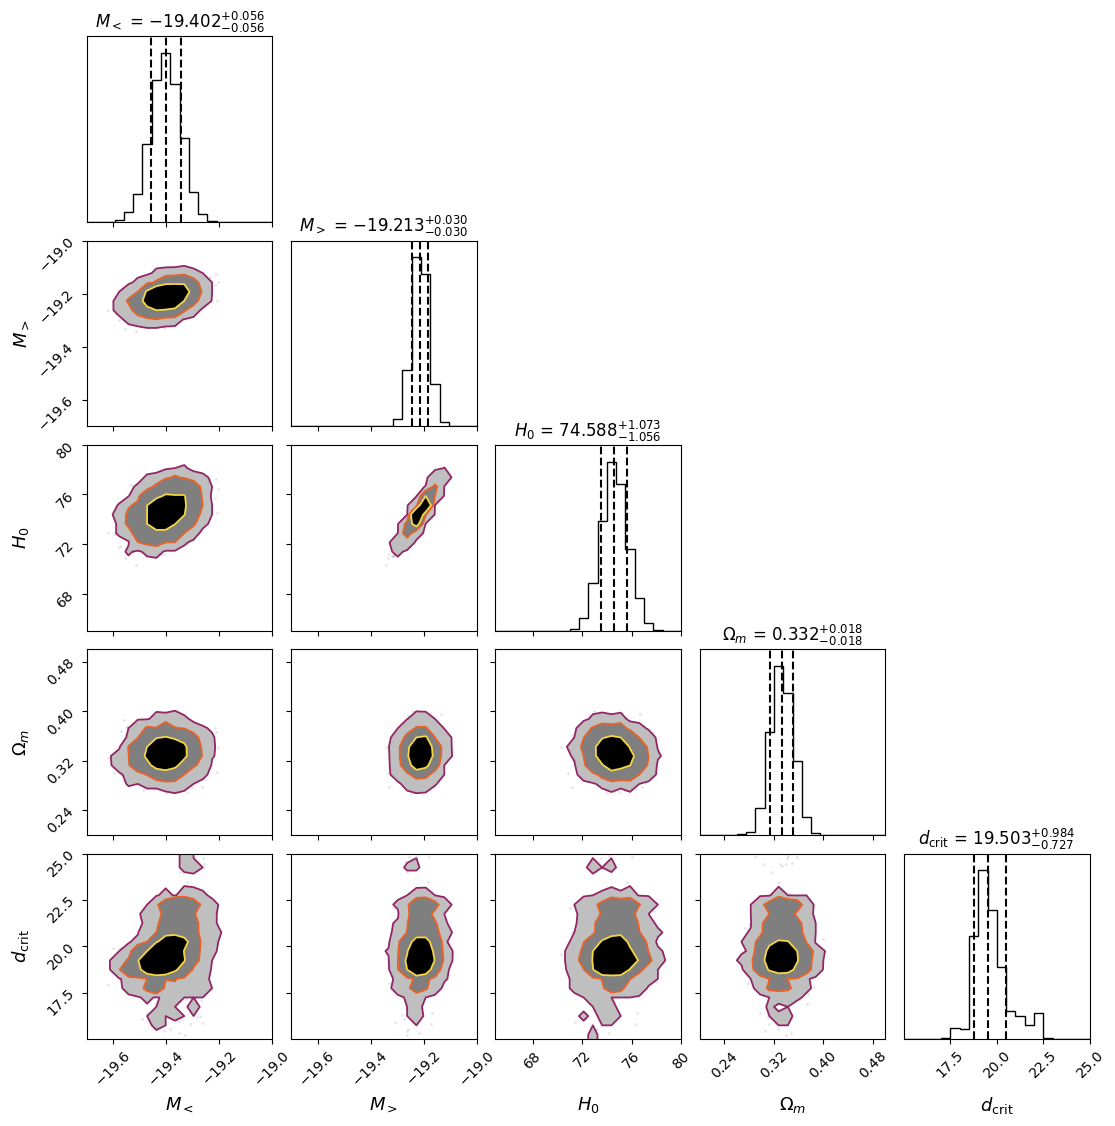

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [32]:
# Load the posterior samples for the transition model
samples_transition_post = np.load("Saved Samples/posterior_samples_transition.npy")

# Parameter labels (should match the order in your samples array)
param_labels = [
    r"$M_{<}$",
    r"$M_{>}$",
    r"$H_0$",
    r"$\Omega_m$",
    r"$d_{\mathrm{crit}}$"
]


# Choose a colormap and compute color shades for different confidence levels
cmap = plt.colormaps["inferno"]  # Try 'magma', 'plasma', 'cividis', etc.
levels = [0.68, 0.95, 0.997]
colors = [cmap(x) for x in np.linspace(0.4, 0.9, len(levels))]

ranges = [
    (-19.7, -19.0),  # M_<
    (-19.7, -19.0),  # M_>
    (65, 80),        # H_0
    (0.20, 0.50),    # Omega_m
    (15, 25)         # d_crit
]

fig = corner.corner(
    samples_transition_post,
    labels=param_labels,
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 13},
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    max_n_ticks=4,
    use_math_text=True,
    range=ranges  
)


# Tighter layout and spacing
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)

# Save and display the figure
fig.savefig("corner_dynesty_transition.png", dpi=300)
plt.show()

# Parameter labels (LaTeX-ready) and optional units
param_labels = [
    r"M_{<}",
    r"M_{>}",
    r"H_0",
    r"\Omega_m",
    r"d_{\mathrm{crit}}"
]
units = ["", "", r"\,\mathrm{km/s/Mpc}", "", r"\,\mathrm{Mpc}"]

# Compute summary statistics
medians = np.median(samples_transition_post, axis=0)
lower = np.percentile(samples_transition_post, 16, axis=0)
upper = np.percentile(samples_transition_post, 84, axis=0)

# Display each parameter in LaTeX
display(Math(r"\textbf{Posterior medians with 68\% credible intervals:}"))
for label, med, low, up, unit in zip(param_labels, medians, lower, upper, units):
    err_minus = med - low
    err_plus = up - med
    display(Math(rf"{label} = {med:.3f}^{{+{err_plus:.3f}}}_{{-{err_minus:.3f}}}{unit}"))

## Comparison between the two models via Bayes Factor

In [15]:
from IPython.display import display, Markdown



# Bayes factor (log evidence difference)
delta_logZ = logZ_trans - logZ_no
delta_logZ_err = (logZerr_no**2 + logZerr_trans**2)**0.5  # combined uncertainty

# LaTeX display
latex_output = fr"""

\begin{{aligned}}
\log \mathcal{{Z}}_\text{{No-Transition}} &= {logZ_no:.2f} \pm {logZerr_no:.2f} \\
\log \mathcal{{Z}}_\text{{Transition}} &= {logZ_trans:.2f} \pm {logZerr_trans:.2f} \\
\Delta \log \mathcal{{Z}} &= {delta_logZ:.2f} \pm {delta_logZ_err:.2f}
\end{{aligned}}

"""
display(Markdown(latex_output))

# Interpretation based on Jeffreys' scale
if delta_logZ > 5:
    interpretation = "Decisive evidence for the transition model."
elif delta_logZ > 2.5:
    interpretation = "Strong evidence for the transition model."
elif delta_logZ > 1:
    interpretation = "Substantial evidence for the transition model."
elif delta_logZ > 0:
    interpretation = "Weak evidence for the transition model."
elif delta_logZ > -1:
    interpretation = "Weak evidence for the no-transition model."
elif delta_logZ > -2.5:
    interpretation = "Substantial evidence for the no-transition model."
elif delta_logZ > -5:
    interpretation = "Strong evidence for the no-transition model."
else:
    interpretation = "Decisive evidence for the no-transition model."

display(Markdown(f"**Interpretation**: {interpretation}"))




\begin{aligned}
\log \mathcal{Z}_\text{No-Transition} &= -771.45 \pm 0.24 \\
\log \mathcal{Z}_\text{Transition} &= -767.49 \pm 0.28 \\
\Delta \log \mathcal{Z} &= 3.96 \pm 0.37
\end{aligned}



**Interpretation**: Strong evidence for the transition model.

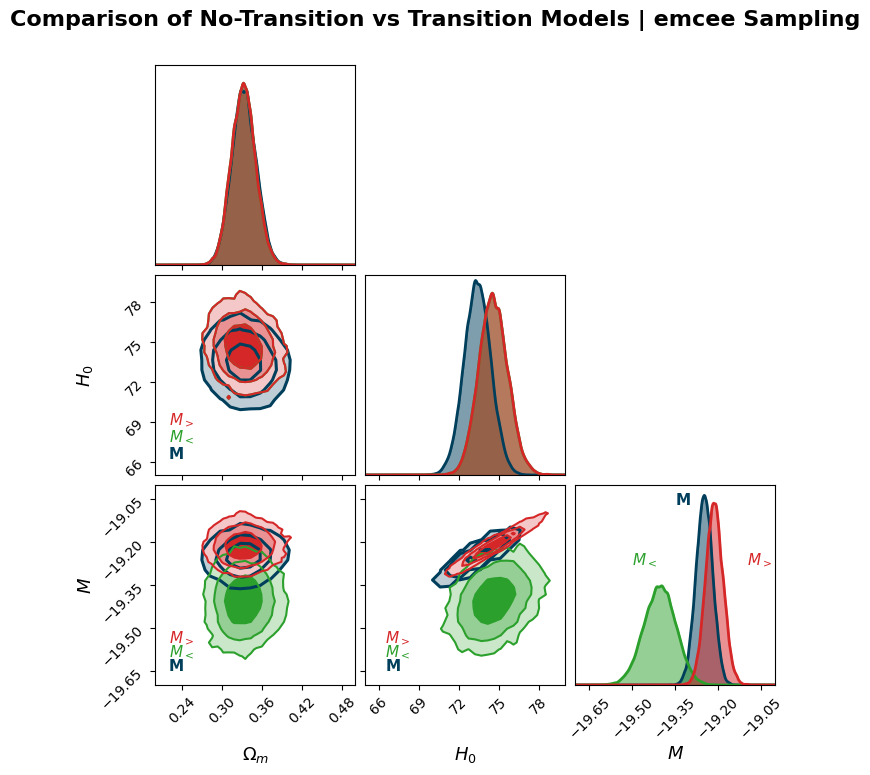

In [3]:
# Load samples
samples_no = np.load("Saved Samples/samples_chain_4000steps.npy")
samples_tr = np.load("Saved Samples/samples_transition_5000steps.npy")

# Reorder: [Omega_m, H0, M]
samples_M = samples_no[:, [2, 1, 0]]
samples_Mlow = samples_tr[:, [3, 2, 0]]
samples_Mhigh = samples_tr[:, [3, 2, 1]]

# Labels and ranges
param_labels = [r"$\Omega_m$", r"$H_0$", r"$M$"]
ranges = [(0.20, 0.50), (65, 80), (-19.7, -19.0)]

# Color scheme
colors = {
    "M": "#003f5c",   # light blue
    "M_low": "#2ca02c", # vibrant green
    "M_high": "#d62728" # rich red
}

# --- Step 1: Base corner plot (no histograms)
fig = corner.corner(
    samples_M,
    labels=param_labels,
    range=ranges,
    color=colors["M"],
    fill_contours=True,
    plot_contours=True,
    plot_density=False,
    plot_datapoints=False,
    hist_kwargs={"linewidth": 0},
    levels=[0.68, 0.95, 0.997],
    contour_kwargs={"linewidths": 2.2},  # Slightly thicker blue lines
    show_titles=False,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 13},
    max_n_ticks=4,
    use_math_text=True
)
fig.suptitle("Comparison of No-Transition vs Transition Models | emcee Sampling", fontsize=16, weight='bold', y=1.02)


# Overlay M< and M> with no histograms
corner.corner(
    samples_Mlow,
    fig=fig,
    color=colors["M_low"],
    fill_contours=True,
    plot_contours=True,
    plot_density=False,
    plot_datapoints=False,
    hist_kwargs={"linewidth": 0},
    levels=[0.68, 0.95, 0.997],
    contour_kwargs={"linewidths": 1.5}
)

corner.corner(
    samples_Mhigh,
    fig=fig,
    color=colors["M_high"],
    fill_contours=True,
    plot_contours=True,
    plot_density=False,
    plot_datapoints=False,
    hist_kwargs={"linewidth": 0},
    levels=[0.68, 0.95,0.997],
    contour_kwargs={"linewidths": 1.5}
)

# --- Step 2: Smooth shaded KDEs on diagonals
axes = np.array(fig.axes).reshape((3, 3))
samples_dict = {
    colors["M"]: samples_M,
    colors["M_low"]: samples_Mlow,
    colors["M_high"]: samples_Mhigh
}

for color, samples in samples_dict.items():
    for i in range(3):
        data = samples[:, i]
        kde = gaussian_kde(data)
        x = np.linspace(*ranges[i], 300)
        y = kde(x)
        ax = axes[i, i]
        ax.plot(x, y, color=color, lw=2)
        ax.fill_between(x, y, color=color, alpha=0.5)
        ax.set_ylim(0, y.max() * 1.1)

# --- Step 3: Add annotations to 2D panels
# Each (row, col) maps to a panel with y = param[row], x = param[col]
labels_2D = {
    (2, 1): {"M": (66.5, -19.65), "M<": (66.5, -19.60), "M>": (66.5, -19.55)},
    (2, 0): {"M": (0.22, -19.65), "M<": (0.22, -19.60), "M>": (0.22, -19.55)},
    (1, 0): {"M": (0.22, 66.2), "M<": (0.22, 67.5), "M>": (0.22, 68.8)}
}

name_map = {
    "M": "M",
    "M<": r"$M_{<}$",
    "M>": r"$M_{>}$"
}
color_map = {
    "M": colors["M"],
    "M<": colors["M_low"],
    "M>": colors["M_high"]
}

for (i, j), texts in labels_2D.items():
    ax = axes[i, j]
    for key, (x, y) in texts.items():
        ax.text(x, y, name_map[key], fontsize=11, color=color_map[key], weight="bold")
ax_M = axes[2, 2]
ymax = ax_M.get_ylim()[1]# Add text annotations
ax_M.text(-19.35, ymax * 0.9, "M", color=colors["M"], fontsize=11, weight="bold")
ax_M.text(-19.50, ymax * 0.6, r"$M_{<}$", color=colors["M_low"], fontsize=11, weight="bold")
ax_M.text(-19.10, ymax * 0.6, r"$M_{>}$", color=colors["M_high"], fontsize=11, weight="bold")

# Save and show
plt.savefig("Combined Corner Plot.png", dpi=300)
plt.show()




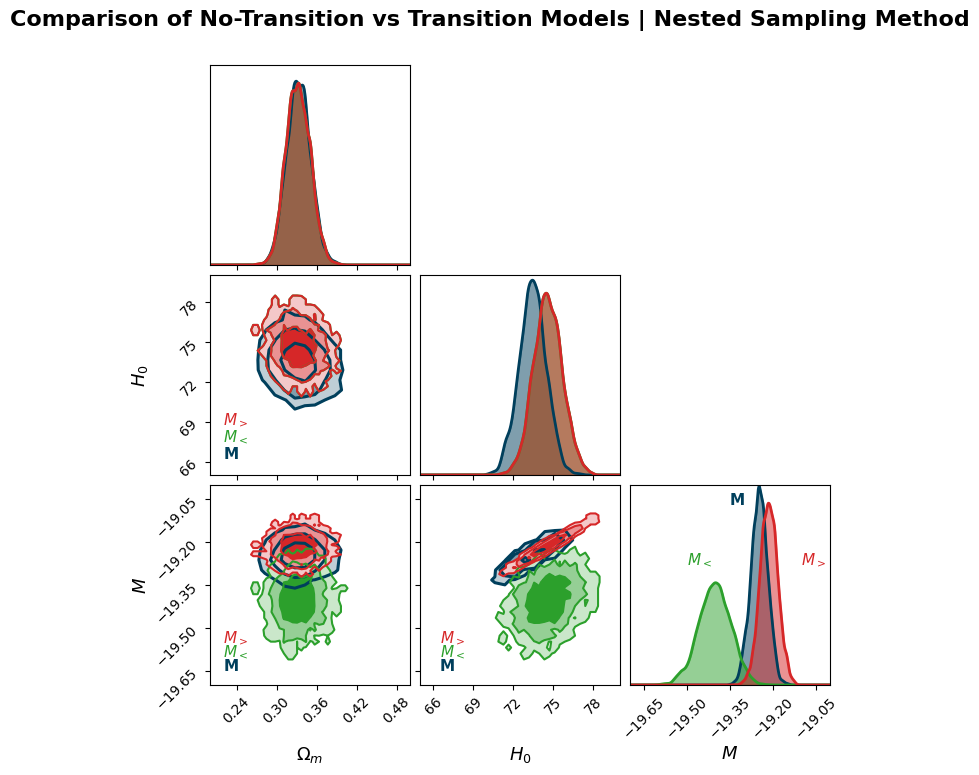

In [5]:
# --- Load nested sampling posterior samples ---
samples_no = np.load("Saved Samples/posterior_samples_no_transition.npy")
samples_tr = np.load("Saved Samples/posterior_samples_transition.npy")

# Reorder: [Omega_m, H0, M]
samples_M = samples_no[:, [2, 1, 0]]
samples_Mlow = samples_tr[:, [3, 2, 0]]
samples_Mhigh = samples_tr[:, [3, 2, 1]]

# Labels and ranges
param_labels = [r"$\Omega_m$", r"$H_0$", r"$M$"]
ranges = [(0.20, 0.50), (65, 80), (-19.7, -19.0)]

# Color scheme
colors = {
    "M": "#003f5c",     # dark blue
    "M_low": "#2ca02c", # green
    "M_high": "#d62728" # red
}

# --- Step 1: Base corner plot (no histograms) ---
fig = corner.corner(
    samples_M,
    labels=param_labels,
    range=ranges,
    color=colors["M"],
    fill_contours=True,
    plot_contours=True,
    plot_density=False,
    plot_datapoints=False,
    hist_kwargs={"linewidth": 0},
    levels=[0.68, 0.95, 0.997],
    contour_kwargs={"linewidths": 2.2},
    show_titles=False,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 13},
    max_n_ticks=4,
    use_math_text=True
)

fig.suptitle("Comparison of No-Transition vs Transition Models | Nested Sampling Method", 
             fontsize=16, weight='bold', y=1.02)

# --- Step 2: Overlay M< and M> ---
corner.corner(
    samples_Mlow, fig=fig, color=colors["M_low"],
    fill_contours=True, plot_contours=True,
    plot_density=False, plot_datapoints=False,
    hist_kwargs={"linewidth": 0},
    levels=[0.68, 0.95, 0.997],
    contour_kwargs={"linewidths": 1.5}
)

corner.corner(
    samples_Mhigh, fig=fig, color=colors["M_high"],
    fill_contours=True, plot_contours=True,
    plot_density=False, plot_datapoints=False,
    hist_kwargs={"linewidth": 0},
    levels=[0.68, 0.95, 0.997],
    contour_kwargs={"linewidths": 1.5}
)

# --- Step 3: KDEs on diagonal
axes = np.array(fig.axes).reshape((3, 3))
samples_dict = {
    colors["M"]: samples_M,
    colors["M_low"]: samples_Mlow,
    colors["M_high"]: samples_Mhigh
}

for color, samples in samples_dict.items():
    for i in range(3):
        data = samples[:, i]
        kde = gaussian_kde(data)
        x = np.linspace(*ranges[i], 300)
        y = kde(x)
        ax = axes[i, i]
        ax.plot(x, y, color=color, lw=2)
        ax.fill_between(x, y, color=color, alpha=0.5)
        ax.set_ylim(0, y.max() * 1.1)

# --- Step 4: Panel annotations
labels_2D = {
    (2, 1): {"M": (66.5, -19.65), "M<": (66.5, -19.60), "M>": (66.5, -19.55)},
    (2, 0): {"M": (0.22, -19.65), "M<": (0.22, -19.60), "M>": (0.22, -19.55)},
    (1, 0): {"M": (0.22, 66.2), "M<": (0.22, 67.5), "M>": (0.22, 68.8)}
}

name_map = {"M": "M", "M<": r"$M_{<}$", "M>": r"$M_{>}$"}
color_map = {"M": colors["M"], "M<": colors["M_low"], "M>": colors["M_high"]}

for (i, j), texts in labels_2D.items():
    ax = axes[i, j]
    for key, (x, y) in texts.items():
        ax.text(x, y, name_map[key], fontsize=11, color=color_map[key], weight="bold")

# 1D posterior annotations
ax_M = axes[2, 2]
ymax = ax_M.get_ylim()[1]
ax_M.text(-19.35, ymax * 0.9, "M", color=colors["M"], fontsize=11, weight="bold")
ax_M.text(-19.50, ymax * 0.6, r"$M_{<}$", color=colors["M_low"], fontsize=11, weight="bold")
ax_M.text(-19.10, ymax * 0.6, r"$M_{>}$", color=colors["M_high"], fontsize=11, weight="bold")

# --- Save and display
plt.savefig("Combined Corner Plot (Nested Sampling).png", dpi=300)
plt.show()
